Parameters:

In [9]:
p = 0.95 
scale = 56

Custom functions:

In [10]:
def wrd_div(n, d):
    return n / d if d else 0

def est_coef(x, y): 
    
    n = np.size(x) 
    m_x, m_y = np.mean(x), np.mean(y) 

    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 

    k = SS_xy / SS_xx 
    b = m_y - k*m_x 
  
    return(b, k)

def power_func(x, a, b, c):
    return a*np.power(np.array(x), b)*np.exp(c*np.array(x))

def parab_func(x, a, b, c, d, e):
    return a/np.sqrt(np.power(np.array(x), b)+c*np.array(x)+d)

Import libraries:

In [35]:
from scipy.optimize import curve_fit
from statistics import median
import statsmodels.api as sm
import statistics
import scipy.fftpack

import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.dates as dates
from sklearn import preprocessing
import statsmodels.api as sm

Ignore warnings:

In [12]:
warnings.filterwarnings('ignore')

Read data for TLT(Treasuries), SPY(SP500), GLD(Gold) and REIT(American Tower Corp.):

In [13]:
df = pd.ExcelFile('data/data.xlsx').parse('data')
label = ['TLT', 'SPY', 'GOLD']

Format data:

In [14]:
df = df.dropna(how='any', axis=0)
df['DATE'] =  pd.to_datetime(df['DATE']).dt.date
dates = df['DATE'] 

Show time period and records number:

In [15]:
print('Dates:', list(df['DATE'])[0], 'to', list(df['DATE'])[-1])
print('Number of records:', len(df))

Dates: 2004-11-15 to 2019-11-08
Number of records: 783


Drop date feature:

In [16]:
df = df.drop(['DATE'], axis=1) 

Metrics vice horizon:

In [17]:
df_stat, df_hor = [],[]
p_med, p_std, p_var = [], [], []

for i in range(2*scale): 
    
    df_hor.append(i/scale)
    
    df_ret = 100*df.apply(np.log).diff(periods=i)
    p_ret = (1/len(df_ret.columns))*df_ret.sum(axis = 1, skipna = True)
    
    df_med = df_ret.apply(lambda x : x.median())
    df_std = df_ret.apply(lambda x : x.std())
    df_var = df_ret[df_ret <= 0].apply(lambda x : x.abs().quantile(p))
    
    p_med.append(p_ret.median())
    p_std.append(p_ret.std())
    p_var.append(np.quantile(([abs(x) for x in p_ret if x <= 0]), p))
    
    df_stat.append(pd.DataFrame({'Return': df_med, 'Standard': df_std, 'Value at risk': df_var}))

Define statistics:

In [18]:
ass_ret,ass_std,ass_var = [],[],[]

for item in range(len(df.columns)):
    
    ass_ret.append(list([float(df_stat[x]['Return'].iloc[item]) for x in range(2*scale)]))
    ass_std.append(list([float(df_stat[x]['Standard'].iloc[item]) for x in range(2*scale)]))
    ass_var.append(list([float(df_stat[x]['Value at risk'].iloc[item]) for x in range(2*scale)]))

Sharpe ratio for SPY and 1/N:

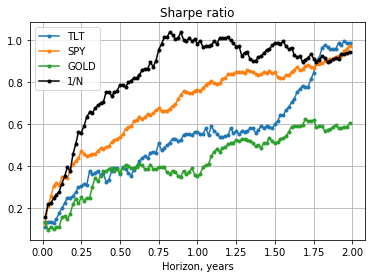

In [19]:
for i in range(len(df.columns)): 
    z = [wrd_div(x,y) for x, y in zip(ass_ret[i], ass_std[i])][1:] 
    plt.plot(df_hor[1:], z, '.-', label=label[i])

plt.plot(df_hor[1:], [wrd_div(x,y) for x, y in zip(p_med, p_std)][1:], '.-', label='1/N', color='black') 
   
plt.title('Sharpe ratio')
plt.xlabel('Horizon, years')
plt.legend(loc='upper left')

plt.grid(True)
plt.show()

Define annualized cumulated returns:

In [20]:
years_num = int(round(len(df)/scale))
df_cum = pd.DataFrame(round(100*(df.iloc[-1]-df.iloc[0])/df.iloc[0]))
df_annual = (df_cum.transpose()/years_num).astype('int64')

Median return vice horizon, saturation for 1/N at annual horizon:

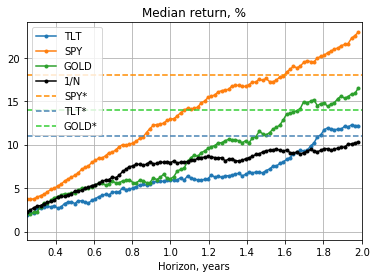

In [21]:
for i in range(len(df.columns)):
    plt.plot(df_hor[1:], ass_ret[i][1:], '.-', label=label[i])

plt.plot(df_hor[1:], p_med[1:], '.-', label='1/N', color='black')

plt.axhline(y=int(df_annual['SPY']), linestyle='--', label='SPY*', color='darkorange')
plt.axhline(y=int(df_annual['TLT']), linestyle='--', label='TLT*', color='steelblue')
plt.axhline(y=int(df_annual['GOLD']), linestyle='--', label='GOLD*', color='limegreen')

plt.title('Median return, %')
plt.xlabel('Horizon, years')

plt.legend(loc='upper left')
plt.xlim(0.25,2)
plt.grid(True)

plt.show()

Value at risk (95%) vice horizon:

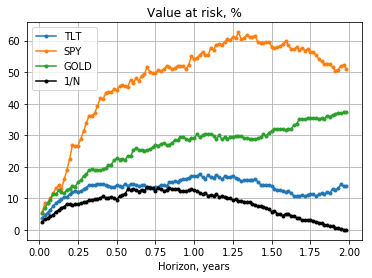

In [22]:
for i in range(len(df.columns)):
    plt.plot(df_hor[1:], ass_var[i][1:], '.-', label=label[i])

plt.plot(df_hor[1:], p_var[1:], '.-', label='1/N', color='black')

plt.title('Value at risk, %')
plt.xlabel('Horizon, years')

plt.legend(loc='upper left')
plt.grid(True)

plt.show()

Return per Var:

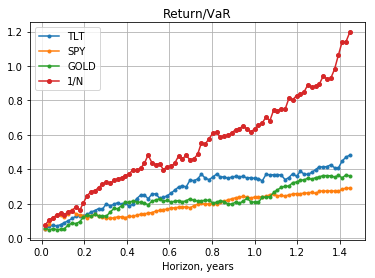

In [23]:
assets_z = []

for i in range(len(df.columns)):
    z = [wrd_div(x,y) for x, y in zip(ass_ret[i][1:], ass_var[i][1:])]
    assets_z.append(z)
    plt.plot(df_hor[1:-30], z[:-30], '.-', label=label[i])

t = [wrd_div(x,y) for x, y in zip(p_med[1:], p_var[1:])]
    
plt.plot(df_hor[1:-30], t[:-30], '.-', markersize=8, label='1/N')
plt.xlabel('Horizon, years')    
    
plt.title('Return/VaR')
plt.xlabel('Horizon, years')

plt.legend(loc='upper left')
plt.grid(True)

plt.show()

Show one year Retun/Var:

In [24]:
for i in range(len(df.columns)):
    print(label[i], 'Return/Var:', round(assets_z[i][scale],2))

TLT Return/Var: 0.35
SPY Return/Var: 0.24
GOLD Return/Var: 0.21


Number of years:

In [25]:
print('Number of years:', years_num)

Number of years: 14


Cumulated return of rebalanced portfolio:

In [26]:
p_cum, p_hor = [], []

for i in range(1, 2*scale):
    
    df_p = df.iloc[::i].apply(np.log).diff(periods=1).dropna(axis = 0)
    df_p = 0.25*df_p.sum(axis=1)
    df_p = 100*(df_p+1).product()-1
    df_p = df_p/years_num
    
    p_hor.append(i/scale)
    p_cum.append(df_p)

Plot cumulated return vice holding period:

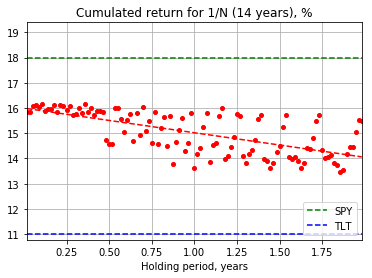

In [27]:
plt.plot(p_hor, p_cum, '.', markersize=8, color='red')

x,y = np.unique(p_hor), np.poly1d(np.polyfit(p_hor, p_cum, 1))
plt.plot(x, y(x), '--', color='red')

plt.axhline(y=int(df_annual['SPY']), linestyle='--', label='SPY', color='green')
plt.axhline(y=int(df_annual['TLT']), linestyle='--', label='TLT', color='blue')

plt.xlim(min(p_hor), max(p_hor))
plt.ylim(0.8*min(p_cum), 1.2*max(p_cum))

plt.xlabel('Holding period, years')
plt.title('Cumulated return for 1/N (14 years), %')
plt.legend(loc='lower right')

plt.grid(True)
plt.show()

Quarter period is ok if consider trading costs. Show statistics of linear regression:

In [28]:
model = sm.OLS(p_hor, p_cum).fit()
reg_stat = model.summary().tables[0]
print(reg_stat)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     282.1
Date:                Wed, 15 Jan 2020   Prob (F-statistic):           3.87e-32
Time:                        11:12:53   Log-Likelihood:                -102.67
No. Observations:                 111   AIC:                             207.3
Df Residuals:                     110   BIC:                             210.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         


Metrics vice horizon for 1/N portfolio with rebalancing:

In [29]:
port_ret, port_std, port_hold, port_var  = [], [], [], []
delta = int(round(0.25*scale))

for j in range(9):  
    
    df_pl = []
    
    for i in range(scale):
        df_p = df.iloc[::delta].apply(np.log).diff(periods=1).dropna(axis = 0)
        df_p = 100*((0.25*df_p.sum(axis=1)+1)[i:(i+j)].product()-1)
        df_pl.append(df_p)
        
    port_ret.append(statistics.median(df_pl))
    port_std.append(statistics.stdev(df_pl))
    port_var.append(np.quantile(([abs(x) for x in df_pl if x <= 0]), p))
    
    port_hold.append(j/4)

Return vice horizon for 1/N portfolio with rebalancing and simple 1/N:

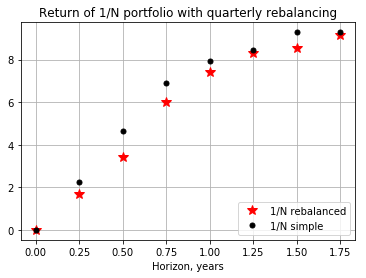

In [30]:
plt.plot(port_hold[:-1], port_ret[:-1], '*', markersize=10, color='red', label='1/N rebalanced')
plt.plot(df_hor[::delta], p_med[::delta], '.', label='1/N simple', color='black', markersize=10)

plt.title('Return of 1/N portfolio with quarterly rebalancing')
plt.xlabel('Horizon, years')
plt.legend(loc='lower right')

plt.grid(True)
plt.show()

Sharpe ratio vice horizon for 1/N portfolio with rebalancing and simple 1/N:

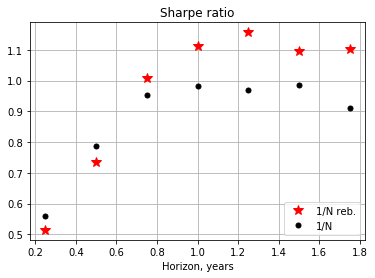

In [31]:
z = [wrd_div(x,y) for x, y in zip(port_ret, port_std)][1:]
t = [wrd_div(x,y) for x, y in zip(p_med, p_std)][::delta][1:]

plt.plot(port_hold[1:][:-1], z[:-1], '*', label='1/N reb.', color='red', markersize=10) 
plt.plot(df_hor[::delta][1:], t, '.', label='1/N', color='black', markersize=10)

plt.title('Sharpe ratio')
plt.xlabel('Horizon, years')
plt.legend(loc='lower right')

plt.grid(True)
plt.show()

Value at risk vice horizon for 1/N portfolio with rebalancing and simple 1/N:

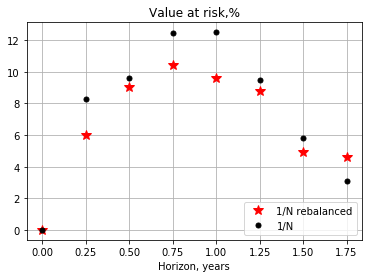

In [32]:
plt.plot(port_hold[:-1], port_var[:-1], '*', markersize=10, color='red', label='1/N rebalanced')
plt.plot(df_hor[::delta], p_var[::delta], '.', label='1/N', color='black', markersize=10)

plt.title('Value at risk,%')
plt.xlabel('Horizon, years')
plt.legend(loc='lower right')

plt.grid(True)
plt.show()

Return/Risk vice horizon for 1/N portfolio with rebalancing and simple 1/N: 

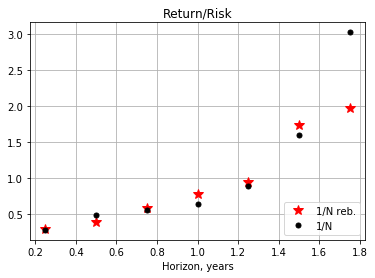

In [33]:
z = [wrd_div(x,y) for x, y in zip(port_ret, port_var)][1:]
t = [wrd_div(x,y) for x, y in zip(p_med, p_var)][::delta][1:]

plt.plot(port_hold[1:][:-1], z[:-1], '*', label='1/N reb.', color='red', markersize=10) 
plt.plot(df_hor[::delta][1:], t, '.', label='1/N', color='black', markersize=10)

plt.title('Return/Risk')
plt.xlabel('Horizon, years')
plt.legend(loc='lower right')

plt.grid(True)
plt.show()